In [1]:
# Download osmnx package
#pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import packages
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, LineString
import math
import networkx as nx
import osmnx as ox

## 1. Download data

use the same method for ukr7 

In [3]:
# download data
try:
    G_ukr1 = ox.graph.graph_from_place("Mariupol, Ukraine", network_type="drive", simplify=True)
    G_ukr1 = G_ukr1.to_undirected()  
    print("success, num of nodes:", len(G_ukr1.nodes))
except Exception as e:
    print(f"fails: {e}")

success, num of nodes: 3975


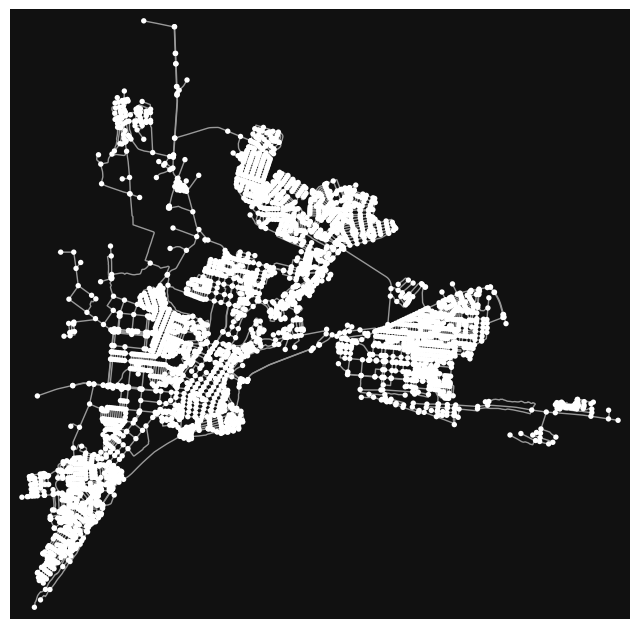

In [4]:
# check the graph
fig, ax = ox.plot_graph(G_ukr1)

In [5]:
# transform to geodataframe
gdf_nodes_ukr1, gdf_edges_urk1 = ox.graph_to_gdfs(G_ukr1)
fields_to_save = ['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref',
       'reversed', 'length', 'geometry', 'bridge', 'junction', 'tunnel',
       'access', 'width']
#gdf_edges_urk1[fields_to_save].to_file("osm_ukr1_py_unclean.shp", driver="ESRI Shapefile")

In [6]:
# check columns
print(gdf_edges_urk1.columns)

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref',
       'reversed', 'length', 'geometry', 'bridge', 'junction', 'tunnel',
       'access', 'width'],
      dtype='object')


In [7]:
# check null values
print(gdf_edges_urk1['highway'].isnull().sum()) 

0


In [8]:
# check index and found that "v" & "u"are the index
print(gdf_edges_urk1.index)

MultiIndex([(   84519135,  1192542079, 0),
            (   84519135,  1195420407, 0),
            (   84519135,  1194078849, 0),
            (   84519135,  9076033095, 0),
            (   84519141,  5584129684, 0),
            (   84519141,  1844212931, 0),
            (   84519141,  1194261491, 0),
            (   84519143,  3732128706, 0),
            (   84519143,  1193943710, 0),
            (   84519143,  1844212933, 0),
            ...
            ( 9077192694,  9105638545, 0),
            ( 9225071013,  9225071014, 0),
            ( 9225071013,  9225090528, 0),
            ( 9225071013,  9225090529, 0),
            ( 9225071014,  9225090521, 0),
            ( 9225090521,  9225090529, 0),
            ( 9225090529,  9225090530, 0),
            ( 9492824162,  9492824163, 0),
            (11999186892, 11999186906, 0),
            (11999186907, 11999186910, 0)],
           names=['u', 'v', 'key'], length=6035)


In [9]:
# reset index
gdf_edges_urk1 = gdf_edges_urk1.reset_index()

In [10]:
# set u & v are columns
print(gdf_edges_urk1.columns)

Index(['u', 'v', 'key', 'osmid', 'highway', 'lanes', 'maxspeed', 'name',
       'oneway', 'ref', 'reversed', 'length', 'geometry', 'bridge', 'junction',
       'tunnel', 'access', 'width'],
      dtype='object')


## 2. Data Cleaning

In [11]:
# extract edges
#osm_ukr1_py = gpd.read_file('osm_ukr1_py_unclean.shp')
osm_ukr1_py = gdf_edges_urk1.copy()
print(osm_ukr1_py.columns)
print(osm_ukr1_py.shape)

Index(['u', 'v', 'key', 'osmid', 'highway', 'lanes', 'maxspeed', 'name',
       'oneway', 'ref', 'reversed', 'length', 'geometry', 'bridge', 'junction',
       'tunnel', 'access', 'width'],
      dtype='object')
(6035, 18)


<Axes: >

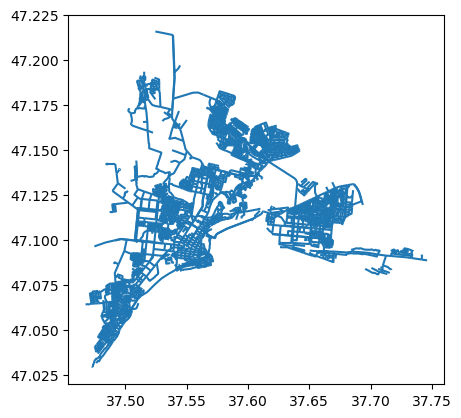

In [12]:
# plot it 
osm_ukr1_py.plot()

In [13]:
# select major roads
major_road_types = [
    "trunk", "trunk_link",
    "primary", "primary_link",
    "secondary","secondary_link",
    "tertiary","tertiary_link"
]
osm_ukr1_py = osm_ukr1_py[osm_ukr1_py['highway'].isin(major_road_types)].copy()
osm_ukr1_py

,u,v,key,osmid,highway,lanes,maxspeed,name,oneway,ref,reversed,length,geometry,bridge,junction,tunnel,access,width
0,84519135,1192542079,0,38939561,trunk,1,50,Шевченка бульвар,True,М-14,False,180.396484,"LINESTRING (37.56465 47.10446, 37.56445 47.104...",NaN,NaN,NaN,NaN,NaN
1,84519135,1195420407,0,91291242,tertiary,2,50,Торгова вулиця,False,NaN,True,168.223144,"LINESTRING (37.56536 47.10586, 37.56492 47.105...",NaN,NaN,NaN,NaN,NaN
2,84519135,1194078849,0,399366618,secondary,3,50,Торгова вулиця,False,NaN,False,11.067169,"LINESTRING (37.56457 47.10438, 37.5646 47.1044...",NaN,NaN,NaN,NaN,NaN
3,84519135,9076033095,0,"[478343683, 103407203, 202280230, 103407207, 1...",trunk,1,50,Пост-міст,True,М-14,False,732.245662,"LINESTRING (37.57281 47.10108, 37.57277 47.101...",yes,NaN,NaN,NaN,NaN
4,84519141,5584129684,0,422801739,secondary,2,50,Торгова вулиця,False,NaN,False,13.141065,"LINESTRING (37.56167 47.09751, 37.56166 47.09739)",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025,9077192694,9105638545,0,"[981300114, 981181525]",trunk,4,40,Набережна вулиця,False,М-14,True,578.364448,"LINESTRING (37.60658 47.11265, 37.60817 47.113...",NaN,NaN,NaN,NaN,NaN
6027,9225071013,9225090528,0,999238329,tertiary,2,50,NaN,True,NaN,False,8.835340,"LINESTRING (37.55382 47.11332, 37.5538 47.1133...",NaN,roundabout,NaN,NaN,NaN
6028,9225071013,9225090529,0,999238329,tertiary,2,50,NaN,True,NaN,False,9.731612,"LINESTRING (37.55394 47.11335, 37.55391 47.113...",NaN,roundabout,NaN,NaN,NaN
6030,9225090521,9225090529,0,264429540,tertiary,3,50,Карпінського вулиця,False,Н-20,True,25.960095,"LINESTRING (37.554 47.11358, 37.55394 47.11335)",NaN,NaN,NaN,NaN,NaN


<Axes: >

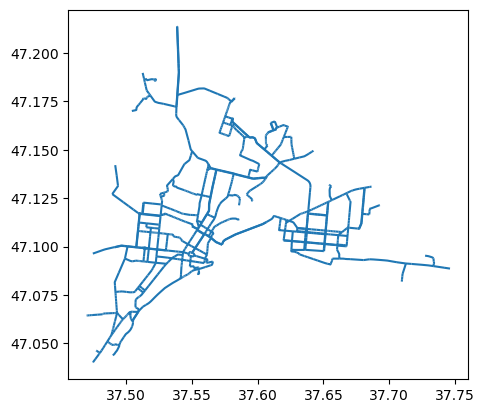

In [14]:
# plot it 
osm_ukr1_py.plot()

In [15]:
# use u & v to remove bidirectional roads
def remove_bidirectional_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    assert all(col in df.columns for col in ['u', 'v']), "DataFrame must contain 'u' and 'v' "

    df = df.copy().reset_index(drop=True) 
    df['pair'] = 0

    processed = [False] * len(df)
    pair_id = 1

    for i in range(len(df)):
        if not processed[i]:
            found = False
            u_i, v_i = df.at[i, 'u'], df.at[i, 'v']

            for j in range(i + 1, len(df)):
                if not processed[j]:
                    u_j, v_j = df.at[j, 'u'], df.at[j, 'v']

                    if u_i == v_j and v_i == u_j:
                        df.at[i, 'pair'] = pair_id
                        df.at[j, 'pair'] = pair_id
                        processed[i] = processed[j] = True
                        pair_id += 1
                        found = True
                        break

            if not found:
                df.at[i, 'pair'] = pair_id
                processed[i] = True
                pair_id += 1

    df['pair'] = df['pair'].astype(int)
    df_unique = df.drop_duplicates(subset='pair', keep='first').reset_index(drop=True)
    return df_unique

In [16]:
osm_ukr1_py = remove_bidirectional_duplicates(osm_ukr1_py)
print(osm_ukr1_py.shape)

(1546, 19)


In [17]:
osm_ukr1_py

,u,v,key,osmid,highway,lanes,maxspeed,name,oneway,ref,reversed,length,geometry,bridge,junction,tunnel,access,width,pair
0,84519135,1192542079,0,38939561,trunk,1,50,Шевченка бульвар,True,М-14,False,180.396484,"LINESTRING (37.56465 47.10446, 37.56445 47.104...",NaN,NaN,NaN,NaN,NaN,1
1,84519135,1195420407,0,91291242,tertiary,2,50,Торгова вулиця,False,NaN,True,168.223144,"LINESTRING (37.56536 47.10586, 37.56492 47.105...",NaN,NaN,NaN,NaN,NaN,2
2,84519135,1194078849,0,399366618,secondary,3,50,Торгова вулиця,False,NaN,False,11.067169,"LINESTRING (37.56457 47.10438, 37.5646 47.1044...",NaN,NaN,NaN,NaN,NaN,3
3,84519135,9076033095,0,"[478343683, 103407203, 202280230, 103407207, 1...",trunk,1,50,Пост-міст,True,М-14,False,732.245662,"LINESTRING (37.57281 47.10108, 37.57277 47.101...",yes,NaN,NaN,NaN,NaN,4
4,84519141,5584129684,0,422801739,secondary,2,50,Торгова вулиця,False,NaN,False,13.141065,"LINESTRING (37.56167 47.09751, 37.56166 47.09739)",NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,9077192694,9105638545,0,"[981300114, 981181525]",trunk,4,40,Набережна вулиця,False,М-14,True,578.364448,"LINESTRING (37.60658 47.11265, 37.60817 47.113...",NaN,NaN,NaN,NaN,NaN,1542
1542,9225071013,9225090528,0,999238329,tertiary,2,50,NaN,True,NaN,False,8.835340,"LINESTRING (37.55382 47.11332, 37.5538 47.1133...",NaN,roundabout,NaN,NaN,NaN,1543
1543,9225071013,9225090529,0,999238329,tertiary,2,50,NaN,True,NaN,False,9.731612,"LINESTRING (37.55394 47.11335, 37.55391 47.113...",NaN,roundabout,NaN,NaN,NaN,1544
1544,9225090521,9225090529,0,264429540,tertiary,3,50,Карпінського вулиця,False,Н-20,True,25.960095,"LINESTRING (37.554 47.11358, 37.55394 47.11335)",NaN,NaN,NaN,NaN,NaN,1545


In [18]:
#osm_ukr1_py.to_file("osm_ukr1_py_pri_clean.geojson", driver="GeoJSON")

In [19]:
#osm_ukr1_py = gpd.read_file('osm_ukr1_py_pri_clean.geojson')
print(osm_ukr1_py.columns)
print(osm_ukr1_py.shape)

Index(['u', 'v', 'key', 'osmid', 'highway', 'lanes', 'maxspeed', 'name',
       'oneway', 'ref', 'reversed', 'length', 'geometry', 'bridge', 'junction',
       'tunnel', 'access', 'width', 'pair'],
      dtype='object')
(1546, 19)


<Axes: >

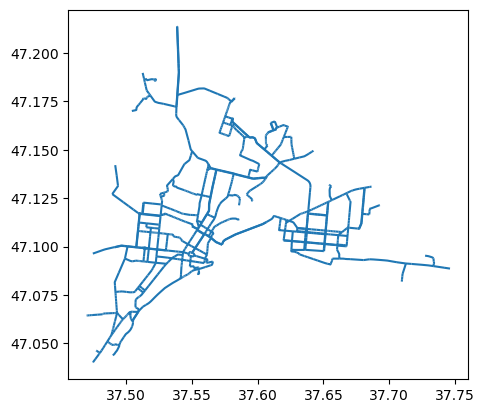

In [20]:
osm_ukr1_py.plot()

In [21]:
# reproject
osm_ukr1 = osm_ukr1_py.to_crs("EPSG:6385")

<Axes: >

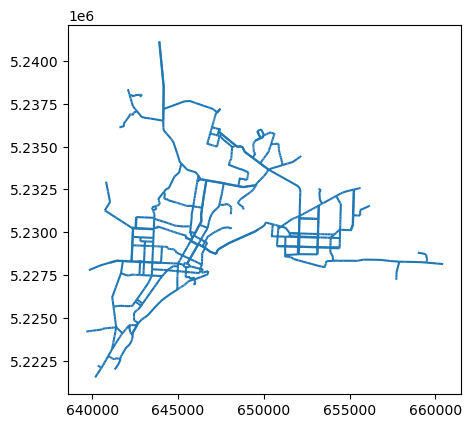

In [22]:
osm_ukr1.plot()

count    1546.000000
mean      166.025433
std       220.648865
min         2.052115
25%        47.143844
50%       102.327948
75%       209.174361
max      2602.992423
Name: length, dtype: float64


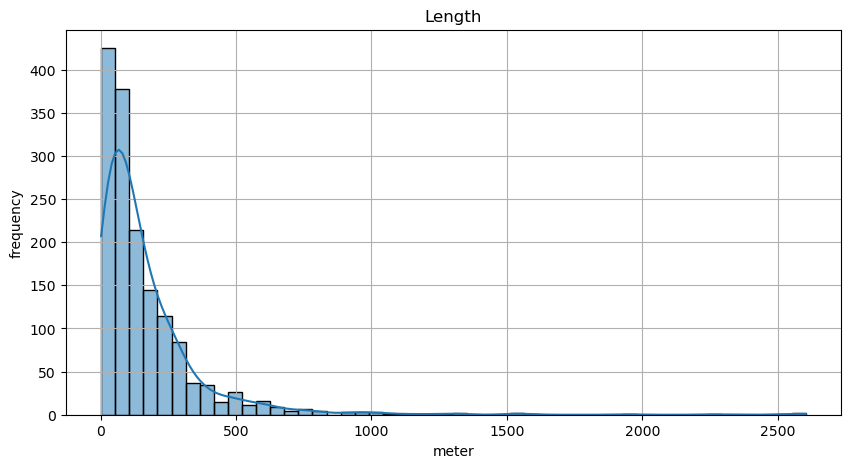

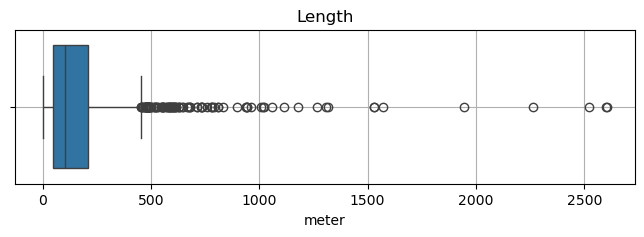

In [23]:
# plot to check the length distribution
import seaborn as sns

print(osm_ukr1['length'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(osm_ukr1['length'], bins=50, kde=True)
plt.title("Length")
plt.xlabel("meter")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

In [26]:
#cut roads function
from shapely.geometry import LineString
from shapely.ops import substring
def segment_roads_by_length(geodf, segment_length):
    from shapely.ops import substring
    segmented_features = []

    geodf = geodf.explode(ignore_index=True)

    for idx, road in geodf.iterrows():
        geom = road.geometry

        if geom is None or geom.is_empty or geom.geom_type != 'LineString':
            continue

        total_length = geom.length
        split_distances = np.arange(0, total_length, segment_length)
        split_distances = np.append(split_distances, total_length)

        for i in range(len(split_distances) - 1):
            start = split_distances[i]
            end = split_distances[i + 1]
            try:
                segment_geom = substring(geom, start, end)
                if segment_geom.is_empty:
                    continue
                new_feature = road.to_dict()
                new_feature['geometry'] = segment_geom
                new_feature['segment_id'] = f"{idx}_{i}"
                new_feature['segment_length'] = segment_geom.length
                segmented_features.append(new_feature)
            except Exception as e:
                print(f"[!] Error segmenting line {idx} segment {i}: {e}")
                continue

    return gpd.GeoDataFrame(segmented_features, crs=geodf.crs)


In [27]:
# cut by 100 meters
osm_ukr1 = segment_roads_by_length(osm_ukr1, 100)
print(osm_ukr1.shape)

(3392, 21)


count    3392.000000
mean       75.890174
std        32.905888
min         0.119698
25%        52.021736
50%       100.000000
75%       100.000000
max       100.000000
Name: segment_length, dtype: float64


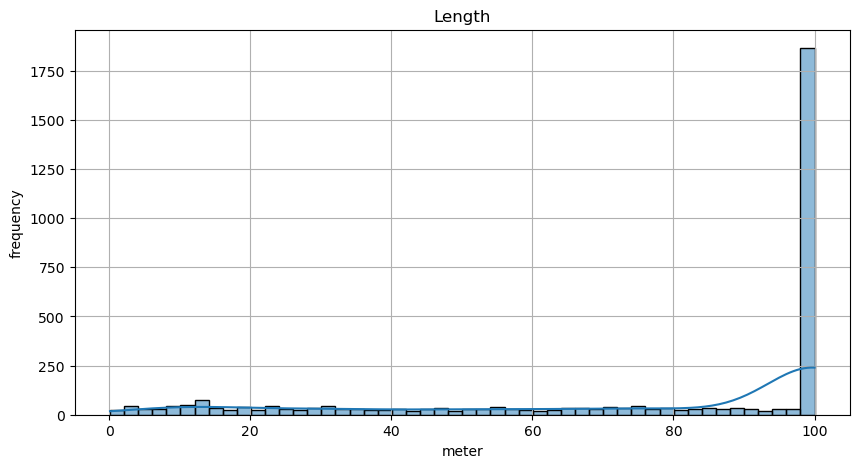

In [28]:
# check the length distribution
print(osm_ukr1['segment_length'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(osm_ukr1['segment_length'], bins=50, kde=True)
plt.title("Length")
plt.xlabel("meter")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

In [29]:
osm_ukr1['length_new'] = osm_ukr1.geometry.length

In [30]:
osm_ukr1

,u,v,key,osmid,highway,lanes,maxspeed,name,oneway,ref,...,bridge,junction,tunnel,access,width,pair,geometry,segment_id,segment_length,length_new
0,84519135,1192542079,0,38939561,trunk,1,50,Шевченка бульвар,True,М-14,...,NaN,NaN,NaN,NaN,NaN,1,"LINESTRING (646580.464 5229088.86, 646564.933 ...",0_0,100.000000,100.000000
1,84519135,1192542079,0,38939561,trunk,1,50,Шевченка бульвар,True,М-14,...,NaN,NaN,NaN,NaN,NaN,1,"LINESTRING (646493.566 5229138.302, 646422.6 5...",0_1,81.026379,81.026379
2,84519135,1195420407,0,91291242,tertiary,2,50,Торгова вулиця,False,NaN,...,NaN,NaN,NaN,NaN,NaN,2,"LINESTRING (646625.831 5229247.34, 646594.914 ...",1_0,100.000000,100.000000
3,84519135,1195420407,0,91291242,tertiary,2,50,Торгова вулиця,False,NaN,...,NaN,NaN,NaN,NaN,NaN,2,"LINESTRING (646586.522 5229157.105, 646583.498...",1_1,68.512741,68.512741
4,84519135,1194078849,0,399366618,secondary,3,50,Торгова вулиця,False,NaN,...,NaN,NaN,NaN,NaN,NaN,3,"LINESTRING (646575.131 5229079.135, 646577.127...",2_0,11.091049,11.091049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387,9077192694,9105638545,0,"[981300114, 981181525]",trunk,4,40,Набережна вулиця,False,М-14,...,NaN,NaN,NaN,NaN,NaN,1542,"LINESTRING (650087.864 5230499.888, 650109.944...",1541_5,80.233034,80.233034
3388,9225071013,9225090528,0,999238329,tertiary,2,50,NaN,True,NaN,...,NaN,roundabout,NaN,NaN,NaN,1543,"LINESTRING (645701.813 5230025.81, 645700.365 ...",1542_0,8.853104,8.853104
3389,9225071013,9225090529,0,999238329,tertiary,2,50,NaN,True,NaN,...,NaN,roundabout,NaN,NaN,NaN,1544,"LINESTRING (645710.783 5230028.92, 645708.34 5...",1543_0,9.770713,9.770713
3390,9225090521,9225090529,0,264429540,tertiary,3,50,Карпінського вулиця,False,Н-20,...,NaN,NaN,NaN,NaN,NaN,1545,"LINESTRING (645713.492 5230054.774, 645710.783...",1544_0,25.995254,25.995254


EPSG:4326
EPSG:6385
(3392, 22)


<Axes: >

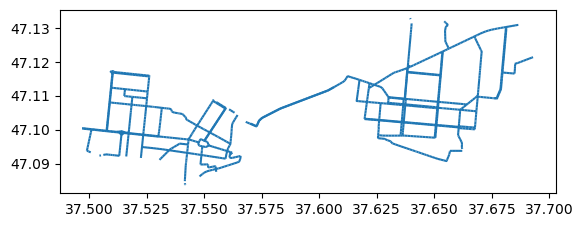

In [32]:
# clip by aoi boundary 
aoi_ukr1 = gpd.read_file("./data/unosat_aois.geojson") # import aoi of ukr1 
print(aoi_ukr1.crs)
print(osm_ukr1.crs)
osm = osm_ukr1.copy().to_crs(epsg=4326)
osm_ukr1_2 = gpd.clip(osm,aoi_ukr1)
print(osm_ukr1.shape)
osm_ukr1_2.plot()

In [33]:
print(osm_ukr1_2.shape)

(1506, 22)


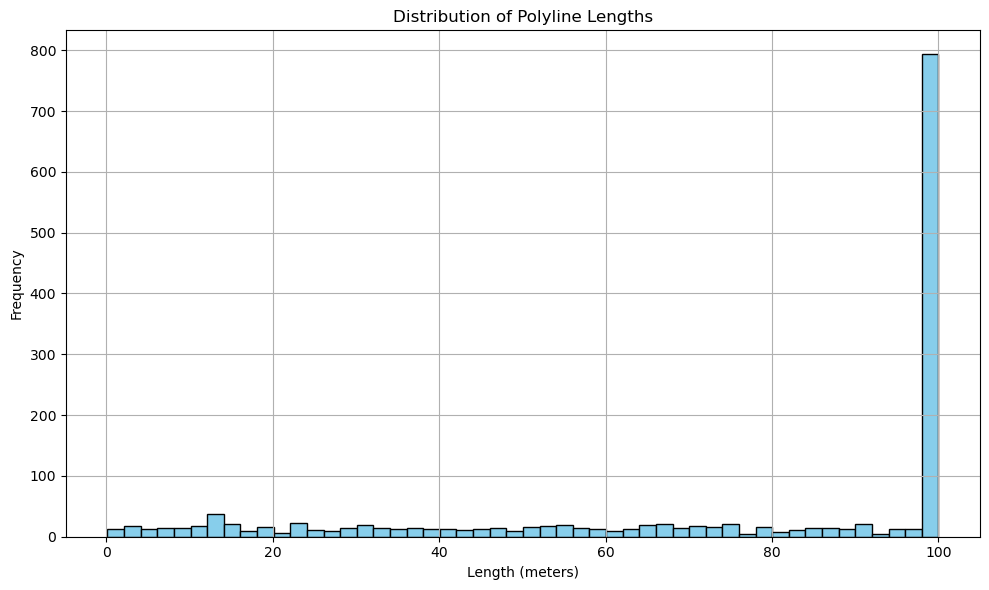

In [34]:
# check it again
plt.figure(figsize=(10, 6))
plt.hist(osm_ukr1_2['length_new'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Polyline Lengths")
plt.xlabel("Length (meters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
osm_ukr1_3 = osm_ukr1_2.copy().to_crs(epsg=6385)

In [36]:
# create buffer
from shapely.geometry import LineString, Polygon
import math

def create_rectangles_from_lines(geodf, offset=2.5):   
    def create_rect_from_segment(segment, offset):
        if not isinstance(segment, LineString) or len(segment.coords) < 2:
            return None
        
        coords = list(segment.coords)
        p_start = coords[0]
        p_end = coords[-1]
        
        dx = p_end[0] - p_start[0]
        dy = p_end[1] - p_start[1]
        seg_len = math.hypot(dx, dy)
        if seg_len == 0:
            return None

        ux = -dy / seg_len
        uy = dx / seg_len

        p1 = (p_start[0] + ux * offset, p_start[1] + uy * offset) 
        p2 = (p_end[0] + ux * offset, p_end[1] + uy * offset)      
        p3 = (p_end[0] - ux * offset, p_end[1] - uy * offset)      
        p4 = (p_start[0] - ux * offset, p_start[1] - uy * offset)  
        
        return Polygon([p1, p2, p3, p4])

    geodf["rect_polygon"] = geodf["geometry"].apply(lambda seg: create_rect_from_segment(seg, offset))
    
    return geodf

In [37]:
# create buffer
osm_ukr1_buffer = create_rectangles_from_lines(osm_ukr1_3, offset=3.75)
print(osm_ukr1_buffer.shape)

(1506, 23)


In [38]:
# save as shp

osm_ukr1_buffer = gpd.GeoDataFrame(osm_ukr1_buffer[['rect_polygon']].copy(),
                            geometry='rect_polygon',
                            crs=osm_ukr1_buffer.crs)

osm_ukr1_buffer = osm_ukr1_buffer.rename(columns={'rect_polygon':'geometry'})
osm_ukr1_buffer = osm_ukr1_buffer.set_geometry('geometry')

print(osm_ukr1_buffer.shape)

#gdf_rect.to_file("gdf_rect_10_2.shp", driver="ESRI Shapefile")

(1506, 1)


In [39]:
print(osm_ukr1_buffer.crs)

EPSG:6385


In [40]:
# adjust for gee
from shapely.affinity import translate
osm_ukr1_buffer_2 = osm_ukr1_buffer.copy()
osm_ukr1_buffer_2['geometry'] = osm_ukr1_buffer_2['geometry'].apply(
    lambda geom: translate(geom, xoff=-110, yoff=-15)
)

<Axes: >

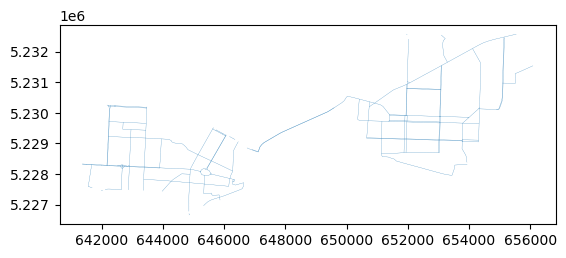

In [41]:
osm_ukr1_buffer_2.plot()

In [ ]:
#osm_ukr1_buffer_2.to_file("osm_ukr1_buffer_50_75_8.shp", driver="ESRI Shapefile")